In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

Found existing installation: lightgbm 3.3.1
Uninstalling lightgbm-3.3.1:
  Successfully uninstalled lightgbm-3.3.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached lightgbm-3.3.1-py3-none-manylinux1_x86_64.whl (2.0 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 5
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'url', 
              'phone', 'categories', 'country']
    vec_columns = ['name', 'categories', 'address', 
                  'state', 'url', 'country']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
def recall_knn(df, Neighbors = 10):
    print('Start knn grouped by country')
    train_df_country = []
    for country, country_df in tqdm(df.groupby('country')):
        country_df = country_df.reset_index(drop = True)

        neighbors = min(len(country_df), Neighbors)
        knn = KNeighborsRegressor(n_neighbors = neighbors,
                                    metric = 'haversine',
                                    n_jobs = -1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude', 'longitude']], 
                                        return_distance = True)

        for k in range(neighbors):            
            cur_df = country_df[['id', 'point_of_interest']]
            cur_df['match_id'] = country_df['id'].values[nears[:, k]]
            cur_df['kdist_country'] = dists[:, k]
            cur_df['kneighbors_country'] = k
            
            
            train_df_country.append(cur_df)
    train_df_country = pd.concat(train_df_country)
    
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.merge(train_df_country,
                                 on = ['id', 'match_id'],
                                 how = 'outer')
    del train_df_country

    train_df['kdist_diff'] = (train_df['kdist'] - train_df['kdist_country']) /\
                    train_df['kdist_country']
    train_df['kneighbors_mean'] = train_df[['kneighbors', 'kneighbors_country']].mean(axis = 1)
    
    return train_df

In [ ]:
def add_features(df):    
    for col in tqdm(CFG.feat_columns):       
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
            
    return df

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [ ]:
data['POI_count'] = data['point_of_interest'].map(dict(data.groupby('point_of_interest')['id'].apply(len)))
data.loc[data['POI_count'] > 5, 'POI_count'] = 5
data['POI_count'] -= 1
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,1
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,1


In [ ]:
distrs = [get_distribution(data['POI_count'])]
index = ['training set']

for set_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(data, data['POI_count'], data["point_of_interest"], k=2, seed=CFG.SEED)):
    data.loc[val_ind, "set"] = set_ind

    dev_y, val_y = data.loc[dev_ind, 'POI_count'], data.loc[val_ind, 'POI_count']
    dev_groups, val_groups = data.loc[dev_ind, "point_of_interest"], data.loc[val_ind, "point_of_interest"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - set {set_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - set {set_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(data['POI_count']) + 1)])

'Distribution per class:'

,Label 0,Label 1,Label 2,Label 3,Label 4
training set,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 0,37.32%,48.77%,6.38%,2.08%,5.44%
validation set - set 0,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 1,37.32%,48.77%,6.38%,2.09%,5.44%
validation set - set 1,37.32%,48.77%,6.38%,2.08%,5.44%


In [ ]:
# Data split
print('Num of train data: %s' % len(data))
print(data['set'].value_counts())

train_data = data.loc[data['set'] == 0]
test_data = data.loc[data['set'] == 1]

print('Train data: ')
analysis(train_data)
print('Test data: ')
analysis(test_data)

train_poi = train_data['point_of_interest'].unique().tolist()
test_poi = test_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(test_poi))

train_ids = train_data['id'].unique().tolist()
test_ids = test_data['id'].unique().tolist()
      
print(set(train_ids) & set(test_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['test_ids'] = test_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, test_data
gc.collect()

data = data.set_index('id')
data = data.reset_index()

Num of train data: 1138812
0.0    569408
1.0    569404
Name: set, dtype: int64
Train data: 
Num of data: 569408
Num of unique id: 569408
Num of unique poi: 369986
Mean num of unique poi: 1.538998772926543
Test data: 
Num of data: 569404
Num of unique id: 569404
Num of unique poi: 369986
Mean num of unique poi: 1.538987961706659
set()
set()


In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tfidf.fit(data.loc[data['set'] == 0, col].fillna('nan'))
    tv_fit = tfidf.transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = recall_knn(data.loc[data['set'] == 0], CFG.num_neighbors)
test_data = recall_knn(data.loc[data['set'] == 1], CFG.num_neighbors)

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)

test_ids = test_data['id'].tolist()
test_match_ids = test_data['match_id'].tolist()

test_poi = data.loc[test_ids]['point_of_interest'].values
test_match_poi = data.loc[test_match_ids]['point_of_interest'].values

test_data['label'] = np.array(test_poi == test_match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids, test_poi, test_match_poi, test_ids, test_match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn grouped by country


  0%|          | 0/206 [00:00<?, ?it/s]

Start knn
Start knn grouped by country


  0%|          | 0/209 [00:00<?, ?it/s]

Start knn
Num of unique id: 569408
Num of train data: 13916774
Pos rate: 0.07237136997410464
                       id          match_id     kdist  kneighbors  \
9669022  E_fb2423f3ecb535  E_ef0bc5de79e10b  0.002962        16.0   
4179479  E_5711e77f4f6716  E_88601b987e6f2c  0.013405         7.0   
2843346  E_fe5b07e0a8a9c5  E_0cffaaebc584d9  0.006918         4.0   
5672212  E_f624aa54796b00  E_b227f88db2fe18  0.003901         9.0   
1412325  E_7b07bee29838a7  E_8d81634e3378a0  0.001450         2.0   

        point_of_interest  kdist_country  kneighbors_country  kdist_diff  \
9669022  P_7aeff722d67fa9       0.001594                 8.0    0.858537   
4179479  P_728ab357db351e       0.013241                 7.0    0.012328   
2843346  P_5f256e9da11ffe       0.004618                 6.0    0.498116   
5672212  P_1ef23c0ca7dfdf       0.002758                 7.0    0.414395   
1412325  P_4507ac6a9d85a4       0.000710                 2.0    1.043830   

         kneighbors_mean  label  
9

In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df_ = test_data[test_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 1138812
Unique id: 1138812
IoU score: 0.9226548761979743


In [ ]:
distrs = [get_distribution(train_data["label"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train_data, train_data["label"], train_data["point_of_interest"], k=CFG.num_split, seed=CFG.SEED)):
    train_data.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train_data.loc[dev_ind, "label"], train_data.loc[val_ind, "label"]
    dev_groups, val_groups = train_data.loc[dev_ind, "point_of_interest"], train_data.loc[val_ind, "point_of_interest"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train_data["label"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,92.76%,7.24%
development set - fold 0,91.67%,8.33%
validation set - fold 0,95.68%,4.32%
development set - fold 1,93.01%,6.99%
validation set - fold 1,91.66%,8.34%
development set - fold 2,93.01%,6.99%
validation set - fold 2,91.67%,8.33%
development set - fold 3,93.01%,6.99%
validation set - fold 3,91.66%,8.34%
development set - fold 4,93.00%,7.00%


# model learning

In [ ]:
data = data.set_index('id')
train_data = add_features(train_data)

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
features = ['kdist','kneighbors','kdist_country','kneighbors_country', 'kdist_diff', 'kneighbors_mean']

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

print(len(features))
print(features)

71
['kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'kdist_diff', 'kneighbors_mean', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'zip_gesh', 'zip_jaro', 'zip_lcs', 'zip_leven', 'country_leven', 'country_sim', 'country_gesh', 'country_nleven', 'url_gesh', 'url_jaro', 'url_lcs', 'url_leven', 'url_len_diff', 'url_nleven', 'url_nlcsk', 'url_nlcs', 'url_sim', 'phone_gesh', 'phone_jaro', 'phone_lcs', 'phone_leven', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'c

In [ ]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42,
             n_class=None, model_dir=None, folds=None):
    models = []

    trn_idx = folds!=0
    val_idx = folds==0
    X_train, y_train = X[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

    if model_dir is None:
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train, 
            eval_set=[(X_valid, y_valid)],  
            early_stopping_rounds=es_rounds, 
            eval_metric='binary',  
#             verbose=-1)
            verbose=50)
    else:
        with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
            model = pickle.load(f)
        
    oof = model.predict_proba(X_valid)
    models.append(model)
    
    file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb.pkl'))
    pickle.dump(model, open(file, 'wb'))
    print()

    cv = (oof.argmax(axis=-1) == y_valid).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data[features], train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      folds=train_data["fold"].values)

[50]	valid_0's binary_logloss: 0.0341533
[100]	valid_0's binary_logloss: 0.0335445

CV-accuracy: 0.9888672940175656


In [ ]:
del train_data
gc.collect()

323

#Check Feature Importances

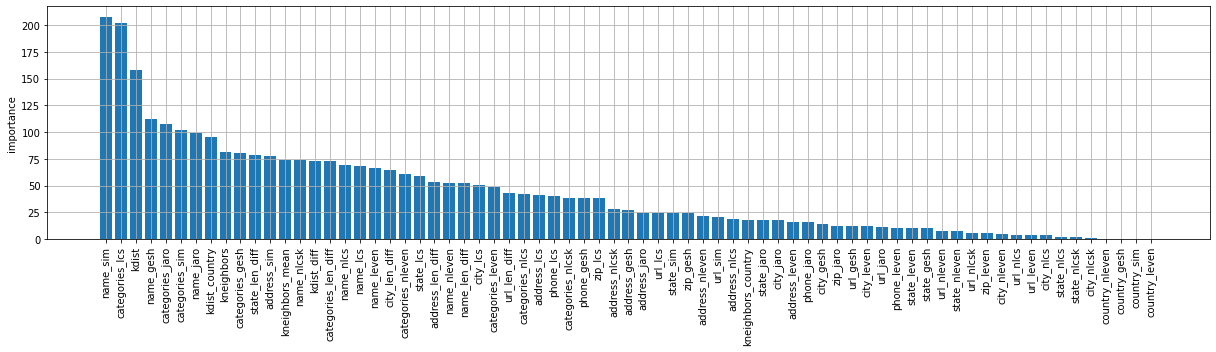

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
test_data = add_features(test_data)
pred = inference_lgb(models, test_data[features])
test_data['pred'] = pred[:, 1]

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    test_pred_df = test_data[test_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = test_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, test_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-25 11:16:07,003] A new study created in memory with name: no-name-684d6b44-29f1-4ab2-be1e-a78ecb4abbd8
[I 2022-05-25 11:16:43,338] Trial 0 finished with value: 0.6993540459466708 and parameters: {'threshold': 0.052347346204332235}. Best is trial 0 with value: 0.6993540459466708.


CV: 0.699354


[I 2022-05-25 11:17:03,997] Trial 1 finished with value: 0.8162551735205245 and parameters: {'threshold': 0.6513507661443464}. Best is trial 1 with value: 0.8162551735205245.


CV: 0.816255


[I 2022-05-25 11:17:39,109] Trial 2 finished with value: 0.33488269150233174 and parameters: {'threshold': 0.0037773667573598457}. Best is trial 1 with value: 0.8162551735205245.


CV: 0.334883


[I 2022-05-25 11:18:01,203] Trial 3 finished with value: 0.7715415859146402 and parameters: {'threshold': 0.1353840035499594}. Best is trial 1 with value: 0.8162551735205245.


CV: 0.771542


[I 2022-05-25 11:18:22,153] Trial 4 finished with value: 0.8086855393469361 and parameters: {'threshold': 0.7283175047551891}. Best is trial 1 with value: 0.8162551735205245.


CV: 0.808686


[I 2022-05-25 11:18:40,626] Trial 5 finished with value: 0.7318649358009245 and parameters: {'threshold': 0.9453458932605407}. Best is trial 1 with value: 0.8162551735205245.


CV: 0.731865


[I 2022-05-25 11:19:01,028] Trial 6 finished with value: 0.8104221087395399 and parameters: {'threshold': 0.7151228748513562}. Best is trial 1 with value: 0.8162551735205245.


CV: 0.810422


[I 2022-05-25 11:19:23,038] Trial 7 finished with value: 0.800750474838738 and parameters: {'threshold': 0.23081338919585848}. Best is trial 1 with value: 0.8162551735205245.


CV: 0.800750


[I 2022-05-25 11:19:43,542] Trial 8 finished with value: 0.8083606364720987 and parameters: {'threshold': 0.7307850403718531}. Best is trial 1 with value: 0.8162551735205245.


CV: 0.808361


[I 2022-05-25 11:20:09,001] Trial 9 finished with value: 0.82076869028401 and parameters: {'threshold': 0.46499303391658264}. Best is trial 9 with value: 0.82076869028401.


CV: 0.820769


[I 2022-05-25 11:20:29,761] Trial 10 finished with value: 0.81868371063999 and parameters: {'threshold': 0.40112043290769694}. Best is trial 9 with value: 0.82076869028401.


CV: 0.818684


[I 2022-05-25 11:20:51,248] Trial 11 finished with value: 0.8196760038608012 and parameters: {'threshold': 0.42762944738470915}. Best is trial 9 with value: 0.82076869028401.


CV: 0.819676


[I 2022-05-25 11:21:11,575] Trial 12 finished with value: 0.8201066296064136 and parameters: {'threshold': 0.43753104363606643}. Best is trial 9 with value: 0.82076869028401.


CV: 0.820107


[I 2022-05-25 11:21:33,179] Trial 13 finished with value: 0.8123425659003954 and parameters: {'threshold': 0.31354280512030325}. Best is trial 9 with value: 0.82076869028401.


CV: 0.812343


[I 2022-05-25 11:22:09,760] Trial 14 finished with value: 0.8209178758581109 and parameters: {'threshold': 0.5328607316416382}. Best is trial 14 with value: 0.8209178758581109.


CV: 0.820918


[I 2022-05-25 11:22:30,190] Trial 15 finished with value: 0.8200542365105797 and parameters: {'threshold': 0.5722290785056037}. Best is trial 14 with value: 0.8209178758581109.


CV: 0.820054


[I 2022-05-25 11:22:49,905] Trial 16 finished with value: 0.7623197401626302 and parameters: {'threshold': 0.9005609500432044}. Best is trial 14 with value: 0.8209178758581109.


CV: 0.762320


[I 2022-05-25 11:23:10,598] Trial 17 finished with value: 0.8197742122504713 and parameters: {'threshold': 0.5796802941799946}. Best is trial 14 with value: 0.8209178758581109.


CV: 0.819774


[I 2022-05-25 11:23:31,382] Trial 18 finished with value: 0.8090185786102085 and parameters: {'threshold': 0.28463352179307544}. Best is trial 14 with value: 0.8209178758581109.


CV: 0.809019


[I 2022-05-25 11:23:51,426] Trial 19 finished with value: 0.7874455689929125 and parameters: {'threshold': 0.8357915401982294}. Best is trial 14 with value: 0.8209178758581109.


CV: 0.787446


[I 2022-05-25 11:24:13,227] Trial 20 finished with value: 0.820967826408323 and parameters: {'threshold': 0.5194812217383828}. Best is trial 20 with value: 0.820967826408323.


CV: 0.820968


[I 2022-05-25 11:24:34,244] Trial 21 finished with value: 0.8208921839404253 and parameters: {'threshold': 0.5362891574342812}. Best is trial 20 with value: 0.820967826408323.


CV: 0.820892


[I 2022-05-25 11:24:54,958] Trial 22 finished with value: 0.8204733438190319 and parameters: {'threshold': 0.5567195671861019}. Best is trial 20 with value: 0.820967826408323.


CV: 0.820473


[I 2022-05-25 11:25:15,635] Trial 23 finished with value: 0.8163945426044463 and parameters: {'threshold': 0.3585204631235069}. Best is trial 20 with value: 0.820967826408323.


CV: 0.816395


[I 2022-05-25 11:25:36,565] Trial 24 finished with value: 0.8210152315217114 and parameters: {'threshold': 0.5154728534593432}. Best is trial 24 with value: 0.8210152315217114.


CV: 0.821015


[I 2022-05-25 11:25:57,193] Trial 25 finished with value: 0.8156741823890561 and parameters: {'threshold': 0.6592326184262526}. Best is trial 24 with value: 0.8210152315217114.


CV: 0.815674


[I 2022-05-25 11:26:17,256] Trial 26 finished with value: 0.8211853489858417 and parameters: {'threshold': 0.49496768578383676}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.821185


[I 2022-05-25 11:26:38,825] Trial 27 finished with value: 0.8025627857904879 and parameters: {'threshold': 0.240966840133799}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.802563


[I 2022-05-25 11:26:59,594] Trial 28 finished with value: 0.8175377350793231 and parameters: {'threshold': 0.6314434578934387}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.817538


[I 2022-05-25 11:27:20,892] Trial 29 finished with value: 0.7849352475621941 and parameters: {'threshold': 0.16937526324666358}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.784935


[I 2022-05-25 11:27:40,870] Trial 30 finished with value: 0.7948692300861874 and parameters: {'threshold': 0.807422576978156}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.794869


[I 2022-05-25 11:28:01,926] Trial 31 finished with value: 0.8207131335563154 and parameters: {'threshold': 0.4625890345906992}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.820713


[I 2022-05-25 11:28:23,391] Trial 32 finished with value: 0.8209909683742495 and parameters: {'threshold': 0.5188139084834379}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.820991


[I 2022-05-25 11:28:44,566] Trial 33 finished with value: 0.8174285752416912 and parameters: {'threshold': 0.37721041719363696}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.817429


[I 2022-05-25 11:29:05,036] Trial 34 finished with value: 0.817929032525492 and parameters: {'threshold': 0.623435990462954}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.817929


[I 2022-05-25 11:29:25,619] Trial 35 finished with value: 0.8210965253086406 and parameters: {'threshold': 0.5102762616347405}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.821097


[I 2022-05-25 11:29:45,664] Trial 36 finished with value: 0.8143232174290388 and parameters: {'threshold': 0.33284257296471464}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.814323


[I 2022-05-25 11:30:06,464] Trial 37 finished with value: 0.8211653158063219 and parameters: {'threshold': 0.49122445394226205}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.821165


[I 2022-05-25 11:30:26,641] Trial 38 finished with value: 0.812723668457138 and parameters: {'threshold': 0.6942281580230756}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.812724


[I 2022-05-25 11:30:47,428] Trial 39 finished with value: 0.8211420267344508 and parameters: {'threshold': 0.4876771300310793}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.821142


[I 2022-05-25 11:31:07,137] Trial 40 finished with value: 0.8194130328431547 and parameters: {'threshold': 0.5930408596019429}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.819413


[I 2022-05-25 11:31:27,844] Trial 41 finished with value: 0.8203165669137659 and parameters: {'threshold': 0.44352058617997864}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.820317


[I 2022-05-25 11:31:48,341] Trial 42 finished with value: 0.8211630397217266 and parameters: {'threshold': 0.49017061305876297}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.821163


[I 2022-05-25 11:32:09,719] Trial 43 finished with value: 0.8210069936777958 and parameters: {'threshold': 0.47977814149970993}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.821007


[I 2022-05-25 11:32:45,018] Trial 44 finished with value: 0.8182962849680137 and parameters: {'threshold': 0.3926071119542157}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.818296


[I 2022-05-25 11:33:08,122] Trial 45 finished with value: 0.7338581003896907 and parameters: {'threshold': 0.08013017345566337}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.733858


[I 2022-05-25 11:33:29,533] Trial 46 finished with value: 0.8209958473306418 and parameters: {'threshold': 0.4777055846439717}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.820996


[I 2022-05-25 11:33:50,054] Trial 47 finished with value: 0.8194581353330882 and parameters: {'threshold': 0.42026622231170885}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.819458


[I 2022-05-25 11:34:11,368] Trial 48 finished with value: 0.8135420757986528 and parameters: {'threshold': 0.6853346975383385}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.813542


[I 2022-05-25 11:34:31,970] Trial 49 finished with value: 0.8019260456470675 and parameters: {'threshold': 0.7736032192759557}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.801926


[I 2022-05-25 11:34:52,996] Trial 50 finished with value: 0.8187953600190395 and parameters: {'threshold': 0.6074496836148295}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.818795


[I 2022-05-25 11:35:14,132] Trial 51 finished with value: 0.8211560758529111 and parameters: {'threshold': 0.4989292140415456}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.821156


[I 2022-05-25 11:35:34,001] Trial 52 finished with value: 0.8211767064653783 and parameters: {'threshold': 0.4954644770752534}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.821177


[I 2022-05-25 11:35:55,002] Trial 53 finished with value: 0.8195424489058201 and parameters: {'threshold': 0.42315379088803345}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.819542


[I 2022-05-25 11:36:15,117] Trial 54 finished with value: 0.8204729861030988 and parameters: {'threshold': 0.5570803283744266}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.820473


[I 2022-05-25 11:36:36,732] Trial 55 finished with value: 0.821134506113977 and parameters: {'threshold': 0.4878507471873776}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.821135


[I 2022-05-25 11:36:58,717] Trial 56 finished with value: 0.8084663253934287 and parameters: {'threshold': 0.2804235227470803}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.808466


[I 2022-05-25 11:37:20,391] Trial 57 finished with value: 0.8153980328153848 and parameters: {'threshold': 0.3451563670797483}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.815398


[I 2022-05-25 11:37:41,281] Trial 58 finished with value: 0.8200507025920889 and parameters: {'threshold': 0.5732563930254404}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.820051


[I 2022-05-25 11:38:01,740] Trial 59 finished with value: 0.8177143636840848 and parameters: {'threshold': 0.3814688827112302}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.817714


[I 2022-05-25 11:38:23,107] Trial 60 finished with value: 0.8205990529135122 and parameters: {'threshold': 0.4576410279755159}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.820599


[I 2022-05-25 11:38:42,982] Trial 61 finished with value: 0.8210646449798036 and parameters: {'threshold': 0.4842458669284744}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.821065


[I 2022-05-25 11:39:03,514] Trial 62 finished with value: 0.8205461207827733 and parameters: {'threshold': 0.5529020110581967}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.820546


[I 2022-05-25 11:39:24,264] Trial 63 finished with value: 0.8211118807914654 and parameters: {'threshold': 0.5058013359393739}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.821112


[I 2022-05-25 11:39:42,200] Trial 64 finished with value: 0.6597050152887487 and parameters: {'threshold': 0.9957053074686063}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.659705


[I 2022-05-25 11:40:03,101] Trial 65 finished with value: 0.8192152128606967 and parameters: {'threshold': 0.41228638300696396}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.819215


[I 2022-05-25 11:40:24,101] Trial 66 finished with value: 0.8205729349616963 and parameters: {'threshold': 0.45453649751345954}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.820573


[I 2022-05-25 11:40:44,455] Trial 67 finished with value: 0.8159065238410392 and parameters: {'threshold': 0.655411549529501}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.815907


[I 2022-05-25 11:41:05,179] Trial 68 finished with value: 0.8208640218759602 and parameters: {'threshold': 0.5379996818853606}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.820864


[I 2022-05-25 11:41:25,521] Trial 69 finished with value: 0.8115195774307463 and parameters: {'threshold': 0.30559954645957876}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.811520


[I 2022-05-25 11:41:46,349] Trial 70 finished with value: 0.8211190693026817 and parameters: {'threshold': 0.5003514944843134}. Best is trial 26 with value: 0.8211853489858417.


CV: 0.821119


[I 2022-05-25 11:42:07,298] Trial 71 finished with value: 0.8211886393294264 and parameters: {'threshold': 0.4950896702809349}. Best is trial 71 with value: 0.8211886393294264.


CV: 0.821189


[I 2022-05-25 11:42:28,777] Trial 72 finished with value: 0.8193263898892311 and parameters: {'threshold': 0.5967119308412694}. Best is trial 71 with value: 0.8211886393294264.


CV: 0.819326


[I 2022-05-25 11:42:49,912] Trial 73 finished with value: 0.821117743597084 and parameters: {'threshold': 0.48672832519119585}. Best is trial 71 with value: 0.8211886393294264.


CV: 0.821118


[I 2022-05-25 11:43:16,054] Trial 74 finished with value: 0.820902449933551 and parameters: {'threshold': 0.5353014279094696}. Best is trial 71 with value: 0.8211886393294264.


CV: 0.820902


[I 2022-05-25 11:43:37,162] Trial 75 finished with value: 0.8205480461885756 and parameters: {'threshold': 0.4514646581542117}. Best is trial 71 with value: 0.8211886393294264.


CV: 0.820548


[I 2022-05-25 11:43:57,751] Trial 76 finished with value: 0.8185217808309441 and parameters: {'threshold': 0.39708046187794277}. Best is trial 71 with value: 0.8211886393294264.


CV: 0.818522


[I 2022-05-25 11:44:19,428] Trial 77 finished with value: 0.8169938967069788 and parameters: {'threshold': 0.36982687663164904}. Best is trial 71 with value: 0.8211886393294264.


CV: 0.816994


[I 2022-05-25 11:44:40,573] Trial 78 finished with value: 0.818130410561753 and parameters: {'threshold': 0.6200583559391898}. Best is trial 71 with value: 0.8211886393294264.


CV: 0.818130


[I 2022-05-25 11:45:01,377] Trial 79 finished with value: 0.8198768413947486 and parameters: {'threshold': 0.4322937362878735}. Best is trial 71 with value: 0.8211886393294264.


CV: 0.819877


[I 2022-05-25 11:45:22,425] Trial 80 finished with value: 0.8203794209080236 and parameters: {'threshold': 0.5596286142963667}. Best is trial 71 with value: 0.8211886393294264.


CV: 0.820379


[I 2022-05-25 11:45:43,580] Trial 81 finished with value: 0.8210815455288635 and parameters: {'threshold': 0.5022725102672668}. Best is trial 71 with value: 0.8211886393294264.


CV: 0.821082


[I 2022-05-25 11:46:03,997] Trial 82 finished with value: 0.8211125247120018 and parameters: {'threshold': 0.5012603521161336}. Best is trial 71 with value: 0.8211886393294264.


CV: 0.821113


[I 2022-05-25 11:46:25,299] Trial 83 finished with value: 0.8209348466848867 and parameters: {'threshold': 0.5269269681322544}. Best is trial 71 with value: 0.8211886393294264.


CV: 0.820935


[I 2022-05-25 11:46:45,528] Trial 84 finished with value: 0.8209445531471614 and parameters: {'threshold': 0.4735848448819619}. Best is trial 71 with value: 0.8211886393294264.


CV: 0.820945


[I 2022-05-25 11:47:06,023] Trial 85 finished with value: 0.8197052888132738 and parameters: {'threshold': 0.5824011814488168}. Best is trial 71 with value: 0.8211886393294264.


CV: 0.819705


[I 2022-05-25 11:47:27,271] Trial 86 finished with value: 0.8205063114627593 and parameters: {'threshold': 0.4499578951679261}. Best is trial 71 with value: 0.8211886393294264.


CV: 0.820506


[I 2022-05-25 11:47:48,104] Trial 87 finished with value: 0.8191783349255957 and parameters: {'threshold': 0.41127942775118886}. Best is trial 71 with value: 0.8211886393294264.


CV: 0.819178


[I 2022-05-25 11:48:08,050] Trial 88 finished with value: 0.8207749125855124 and parameters: {'threshold': 0.5411479217247182}. Best is trial 71 with value: 0.8211886393294264.


CV: 0.820775


[I 2022-05-25 11:48:29,114] Trial 89 finished with value: 0.8211548042470658 and parameters: {'threshold': 0.4918260124054553}. Best is trial 71 with value: 0.8211886393294264.


CV: 0.821155


[I 2022-05-25 11:48:48,683] Trial 90 finished with value: 0.8169293660912517 and parameters: {'threshold': 0.6406224510552609}. Best is trial 71 with value: 0.8211886393294264.


CV: 0.816929


[I 2022-05-25 11:49:09,464] Trial 91 finished with value: 0.8211525164424786 and parameters: {'threshold': 0.489852885939656}. Best is trial 71 with value: 0.8211886393294264.


CV: 0.821153


[I 2022-05-25 11:49:30,044] Trial 92 finished with value: 0.8209840849526178 and parameters: {'threshold': 0.4769691897798364}. Best is trial 71 with value: 0.8211886393294264.


CV: 0.820984


[I 2022-05-25 11:49:50,601] Trial 93 finished with value: 0.820087042220187 and parameters: {'threshold': 0.4371060570777716}. Best is trial 71 with value: 0.8211886393294264.


CV: 0.820087


[I 2022-05-25 11:50:11,658] Trial 94 finished with value: 0.8209566699955714 and parameters: {'threshold': 0.5284079862359014}. Best is trial 71 with value: 0.8211886393294264.


CV: 0.820957


[I 2022-05-25 11:50:32,790] Trial 95 finished with value: 0.8200232176814356 and parameters: {'threshold': 0.574031388000462}. Best is trial 71 with value: 0.8211886393294264.


CV: 0.820023


[I 2022-05-25 11:50:52,828] Trial 96 finished with value: 0.8211492277071559 and parameters: {'threshold': 0.4898253516499135}. Best is trial 71 with value: 0.8211886393294264.


CV: 0.821149


[I 2022-05-25 11:51:13,635] Trial 97 finished with value: 0.8210101437806839 and parameters: {'threshold': 0.5161790478124392}. Best is trial 71 with value: 0.8211886393294264.


CV: 0.821010


[I 2022-05-25 11:51:33,958] Trial 98 finished with value: 0.8207583864077401 and parameters: {'threshold': 0.4651007699321097}. Best is trial 71 with value: 0.8211886393294264.


CV: 0.820758


[I 2022-05-25 11:51:55,005] Trial 99 finished with value: 0.8204686768175844 and parameters: {'threshold': 0.5568914257149927}. Best is trial 71 with value: 0.8211886393294264.


CV: 0.820469


In [ ]:
threshold = study.best_params['threshold']
threshold

0.4950896702809349

In [ ]:
study.best_value

0.8211886393294264

In [ ]:
test_pred_df = test_data[test_data['pred'] > threshold][['id', 'match_id']]
out_df = pd.DataFrame()
out_df['id'] = test_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']
out_df = pd.concat([out_df, test_pred_df])
out_df = out_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
out_df = post_process(out_df)

score = get_score(out_df)
print(f"CV: {score:.6f}")

CV: 0.821189


# 間違っているものの中身を見る

In [ ]:
data = data.reset_index()

labelが1なのに0と予測しているもの

In [ ]:
false_negative = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] <= threshold), :]
false_negative.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,146466.000000,146466.000000,142048.000000,142048.000000,136915.000000,150777.000000,150777.0,150777.000000,150777.000000,150777.000000,...,150777.000000,150773.000000,150773.000000,150773.000000,150773.000000,150777.000000,150773.000000,150773.000000,150773.000000,150777.000000
mean,0.006401,6.259036,0.003486,6.303137,0.420598,6.556657,1.0,0.256628,0.409021,16.432108,...,0.998647,0.998803,0.002474,0.998782,1.997606,0.000027,0.001237,0.998803,0.998803,0.188826
std,0.047311,5.192059,0.022791,5.217326,2.317599,5.263057,0.0,0.304366,0.248930,9.442562,...,0.036758,0.033877,0.069491,0.034520,0.067754,0.005151,0.034745,0.033877,0.033877,0.150842
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000040
25%,0.000438,2.000000,0.000329,2.000000,0.005972,2.000000,1.0,0.000000,0.206897,10.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.050083
50%,0.001098,4.000000,0.000843,5.000000,0.056194,5.000000,1.0,0.000000,0.391304,15.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.157423
75%,0.003064,10.000000,0.002350,10.000000,0.321107,10.000000,1.0,0.504664,0.588235,22.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.314165
max,4.310371,19.000000,2.388985,19.000000,170.784270,19.000000,1.0,1.000000,1.000000,59.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.495088


In [ ]:
false_negative.sample(min(false_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
683571,E_3328361e446529,E_e6ae9be1f76e0e,0.000902,1.0,P_af5443922ce267,0.000894,1.0,0.009098,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.471733
1562925,E_be6260489941bf,E_abadc327440d5b,0.001492,2.0,P_d075f6ea4cd5c2,0.001484,2.0,0.005748,2.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.121476
1512822,E_a7e717dc73ba30,E_2a871d42a9e4d2,0.001233,2.0,P_03ed3221e25fe6,0.001020,2.0,0.208098,2.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.164607
881805,E_8c46e23c70b9cf,E_73f9f5b61fc20b,0.000214,1.0,P_1ed9b4b3b067cc,0.000180,1.0,0.192489,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.395975
8895233,E_9eeddab0e80646,E_162ce54050e1ff,0.003197,15.0,NaN,NaN,NaN,NaN,15.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.235996
837870,E_7891fecb0fd718,E_9888063f46fb63,0.000117,1.0,P_68704061f7cffd,0.000098,3.0,0.195313,2.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.292952
5084933,E_edfd26f4317429,E_c7f3e40926b221,0.001105,8.0,P_a90831ad5e7a63,0.001002,8.0,0.102752,8.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.320023
2281309,E_01ae2eefb1f7e8,E_c550b9bcf57056,0.005534,4.0,P_068653d153c660,0.003695,4.0,0.497789,4.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.229540
1127510,E_fae6a092b74b3c,E_f4ac5a4892eece,0.001718,1.0,P_f0289cb1b28213,0.001586,1.0,0.083206,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.202113
1651442,E_e64d662ced1b93,E_d79ce879e0c071,0.000173,2.0,P_19c705474f6d28,0.000172,2.0,0.004846,2.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.316201


In [ ]:
for id, match_id in false_negative.sample(min(false_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
438456,E_6289d171fd6011,Социология,47.225186,39.709877,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Auditoriums,P_d24e553991baed,4,1.0
902442,E_cab255c05ffb82,Арбитражный Процесс,47.225665,39.709799,Горького 88,Ростов,NaN,NaN,RU,NaN,NaN,College Auditoriums,P_d24e553991baed,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
130794,E_1d5250fdd2ae29,Perumahan Azalea,-5.153741,119.455175,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_e727a518d57ee5,4,1.0
769799,E_ace65f8a760748,Azalea Panakkukang,-5.154760,119.455828,NaN,Panakkukang,South Sulawesi,90233,ID,NaN,NaN,Assisted Living,P_e727a518d57ee5,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
911270,E_ccb70654f8076d,на лестнице🍓,64.569033,39.84146,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Classrooms,P_86afa420d32d95,4,1.0
1073503,E_f142949f372a67,4️⃣этаж 8️⃣гг📚,64.570354,39.83972,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Quads,P_86afa420d32d95,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
595723,E_85e6f454310e82,Töölön sairaala Leikkaussali 1,60.181176,24.920953,NaN,Helsinki,NaN,NaN,FI,NaN,NaN,Hospitals,P_5690bf15377d19,4,1.0
697840,E_9cbc888341cf3c,Osasto 2,60.180886,24.921876,Topeliuksenkatu 5,Helsinki,NaN,NaN,FI,NaN,NaN,Hospitals,P_5690bf15377d19,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
121622,E_1b463fa0e39378,Hastaneden Tavşanlı Manzarası,39.552918,29.484493,hastane ünü düzlük,tavşanlı,Kütahya,43300,TR,NaN,NaN,Mountains,P_fb59ddf3221215,4,1.0
122238,E_1b695ca2c1bf51,Doç.Dr.Mustafa Kalemli Devlet Hastanesi Ameliy...,39.552859,29.483955,NaN,NaN,NaN,NaN,TR,NaN,NaN,Hospitals,P_fb59ddf3221215,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
437081,E_623d3c28fc745c,Крафт на кранах,53.530909,49.341275,40 лет Победы 43 В строение 1,Тольятти,Самарская область,445056,RU,NaN,+78482748898,Beer Stores,P_f49aac49853046,1,1.0
1115321,E_fab969523b570b,Крафт на Кранах,53.530651,49.341125,"40 Лет Победы, 43В, строение 1",Тольятти,Самарская область,445000,RU,NaN,NaN,Beer Stores,P_f49aac49853046,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
203095,E_2d91077b48d47f,arçelik servis alanı,39.747784,30.620470,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_f64132d6f814de,2,1.0
425056,E_5f81b9b42b1b66,Arçelik Buzdolabı İşletmesi,39.745879,30.617571,Organize Sanayi Bölgesi 1.Cadde,Eskişehir,Eskisehir,26110,TR,http://www.arcelikas.com,+902222134343,"Factories, Tech Startups, Coworking Spaces",P_f64132d6f814de,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
533864,E_77fa69aa73e90e,JeJu: Food Court,33.957623,-84.134369,NaN,Duluth,GA,30096,US,NaN,NaN,Food Courts,P_f10696281daa14,2,1.0
1030289,E_e77bcfba08cf73,JeJu Sauna & House of Well Being,33.956852,-84.131101,3555 Gwinnett Place Dr,Duluth,GA,30096,US,http://www.jejusauna.net,6783367414,Bath Houses,P_f10696281daa14,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
851858,E_bf4fdfb93638a8,Pelabuhan Bakauheni-Lampung,-5.866999,105.755871,Jl.Trans Sumatra,Lampung,NaN,NaN,ID,NaN,NaN,Piers,P_2769dafac3aa32,4,1.0
1063021,E_eee8fae86f9482,KMP Mustika,-5.867288,105.768093,NaN,NaN,NaN,NaN,ID,NaN,NaN,Boats or Ferries,P_2769dafac3aa32,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
167991,E_25aa7ed0905ec4,SPAR,46.72196,19.845209,Dr. Holló Lajos utca 74-76.,Kiskunfélegyháza,Bács-Kiskun,6100,HU,https://www.spar.hu/hu_HU/uzletek.html,208237536,Grocery Stores,P_c018aa02377b26,1,1.0
742926,E_a6e8171ee29ebc,Spár (Petőfi lakótelepi),46.71463,19.849161,NaN,NaN,NaN,NaN,HU,NaN,NaN,Grocery Stores,P_c018aa02377b26,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
387687,E_57158ec46dc480,"Маршала Воронова, 16а",56.325742,43.923546,NaN,Nizhny Novgorod,Nizhegorodskaya Oblast’,NaN,RU,NaN,NaN,"Residential Buildings (Apartments / Condos), R...",P_abfcd8af4dc247,1,1.0
1037528,E_e91a421a23e08c,А вот и Я),56.326889,43.927637,NaN,NaN,NaN,NaN,RU,NaN,NaN,Residential Buildings (Apartments / Condos),P_abfcd8af4dc247,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
952855,E_d60a6de239d224,Второй Перрон,59.801874,30.271499,NaN,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_131cce5dba7570,3,1.0
1045718,E_eaf969af1a77bc,Стоянка 111,59.796373,30.258502,NaN,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_131cce5dba7570,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
925423,E_cfdeba0edba6de,LFM - ruang 9009,-6.891992,107.611020,Institu Teknologi Bandung,Bandung,West Java,NaN,ID,NaN,NaN,"College Auditoriums, Indie Movie Theaters, Col...",P_c0b6c63ef004f3,3,1.0
927705,E_d061421edb3252,Sekre LFM ITB,-6.892876,107.611084,Jalan Ganeca 10,Bandung,Jawa Barat,40132,ID,NaN,NaN,"College Theaters, Offices",P_c0b6c63ef004f3,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
215026,E_3044ac04bbcc1f,MARUI,38.005557,138.315018,NaN,NaN,NaN,NaN,JP,NaN,NaN,NaN,P_ee70d972e32726,1,1.0
372466,E_53b0e0c0930903,マルイ 佐渡店,38.005818,138.314876,窪田6-2,佐渡市,新潟県,952-1325,JP,http://www.super-marui.com,+81259522155,Grocery Stores,P_ee70d972e32726,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
761973,E_ab2baed9256992,10-й сектор,59.951485,30.286958,NaN,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_5bfde0c14be347,4,1.0
966841,E_d93047edce626c,VIP Ложа 3,59.951304,30.286260,NaN,NaN,NaN,NaN,RU,NaN,NaN,Soccer Stadiums,P_5bfde0c14be347,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
21414,E_04d0086ac0cc43,Color Living Hotel,13.623876,100.628288,NaN,NaN,NaN,NaN,TH,NaN,NaN,Buildings,P_bee6e384d7093c,4,1.0
800191,E_b3b42a91ab9d3d,เดอะ คัลเลอร์ ลิฟวิ่ง,13.626168,100.632360,NaN,NaN,NaN,NaN,TH,NaN,NaN,Hotels,P_bee6e384d7093c,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
300205,E_4369bf42a43a49,Fuji@Bangna 12 Km.,13.631589,100.712217,NaN,NaN,NaN,NaN,TH,NaN,NaN,Japanese Restaurants,P_2c5ec88636dfec,2,1.0
1046502,E_eb2677d3718e20,Fuji (ฟูจิ),13.630917,100.710323,Tesco Lotus Bangplee,Bang Phli,Samut Prakan,10540,TH,http://www.fuji.co.th,023251067,"Japanese Restaurants, Sushi Restaurants",P_2c5ec88636dfec,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
486748,E_6d64afed3e8130,Офис БД-Селигер :),57.248642,33.078771,NaN,NaN,NaN,NaN,RU,NaN,NaN,Buildings,P_e6eaeae67f4b4b,4,1.0
528144,E_76adafddc448af,Шатер Менделеев,57.247075,33.074203,NaN,NaN,NaN,NaN,RU,NaN,NaN,Event Spaces,P_e6eaeae67f4b4b,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
121348,E_1b35bc67e2d8bb,Post Office,47.221509,-122.475138,3825 S Warner St,Tacoma,WA,98409,US,NaN,NaN,Post Offices,P_c4bacb82206d4e,1,1.0
915026,E_cd8ca8b40f3126,USPS Tacoma Central Carrier Facility,47.221518,-122.480128,3825 S Warner St,Tacoma,WA,98409,US,NaN,NaN,Post Offices,P_c4bacb82206d4e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
282134,E_3f549ec086366d,ΔΙΑΧΡΟΝΙΚΗ ΜΟΥΣΙΚΗ ΣΚΗΝΗ,35.181955,33.388288,NaN,NaN,NaN,NaN,CY,NaN,NaN,Music Venues,P_ed8ec09d68af87,2,1.0
401341,E_5a2ca17fa29c7d,Diaxroniki mousiki skini,35.183678,33.397353,Yianni Koromia 2 Kaimakli,Nicosia,NaN,1028,CY,NaN,99783455,"Nightclubs, Rock Clubs, Other Nightlife",P_ed8ec09d68af87,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
67993,E_0f3734c584990e,oAkshire beer delivery,44.050072,-123.094427,NaN,Eugene,OR,97401,US,NaN,NaN,Pubs,P_2385541ca15fd9,2,1.0
437594,E_6259d95f41ce7f,Oakshire Brewing Public House,44.057492,-123.103030,207 Madison St,Eugene,OR,97402,US,http://oakbrew.com,5416884555,"Breweries, Music Venues",P_2385541ca15fd9,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
106406,E_17d8439082174c,Susanin Fitness,59.849301,30.145019,ТРЦ «Жемчужная Плаза»,Санкт-Петербург,St.-Petersburg,198328,RU,http://susaninfitness.ru,8123070000,"Gyms or Fitness Centers, Gyms",P_b36ab34297e2a8,2,1.0
516722,E_74227145adffb2,Фитнес центр,59.851077,30.145940,NaN,Санкт-Петербург,Санкт-Петербург,198206,RU,NaN,NaN,Gyms,P_b36ab34297e2a8,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
42014,E_09649570f381ce,Beatnixx @ 626NightMarket,34.138137,-118.045067,285 W. Huntington Dr.,Arcadia,CA,91007,US,NaN,NaN,Jewelry Stores,P_5306931fe24ad7,4,1.0
253947,E_3908b87a491b14,626 Night Market Ready Artwork Booth B24,34.137638,-118.044861,285 W. Huntington Dr. Booth B24,Arcadia,CA,91007,US,NaN,6264004511,General Entertainment,P_5306931fe24ad7,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
675976,E_97d639a93ecc94,Pasar Seni Guwang Sukawati,-8.604699,115.280442,NaN,NaN,NaN,NaN,ID,NaN,NaN,"Arts & Crafts Stores, Gift Shops, Clothing Stores",P_493edb4ef974d1,2,1.0
717692,E_a135fb145a24b2,Pasar oleh oleh guwang sukawati,-8.604913,115.280792,NaN,NaN,NaN,NaN,ID,NaN,NaN,Arts & Crafts Stores,P_493edb4ef974d1,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
20535,E_049cf340c105bf,sports authority field suite 448,39.743809,-105.020091,NaN,Denver,CO,80204,US,NaN,NaN,Football Stadiums,P_e7730328b46532,4,1.0
91043,E_146a2f9e1cc630,Mile High Section 302,39.743958,-105.019115,NaN,Denver,CO,80204,US,NaN,NaN,Football Stadiums,P_e7730328b46532,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
393181,E_58564174e5c564,КПП Брусничное,60.932107,28.561885,NaN,NaN,NaN,NaN,RU,NaN,NaN,General Travel,P_f051d6c34641db,4,1.0
428186,E_6036c03e273268,Shayud Cross-Border Office,60.936227,28.559183,NaN,NaN,NaN,NaN,RU,NaN,NaN,Hookah Bars,P_f051d6c34641db,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
137143,E_1ebab2c9ca2f3c,ABSCBN Dressing Room 12,14.639357,121.036256,NaN,NaN,NaN,NaN,PH,NaN,NaN,General Entertainment,P_ac23cd05161794,4,1.0
182436,E_28ede77779ebde,9/F ELJCC ABS-CBN,14.639091,121.035674,NaN,Quezon City,NaN,NaN,PH,NaN,NaN,Offices,P_ac23cd05161794,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
56006,E_0c8a384ac8d49f,Новые Глобально-общественные Изменения,47.225306,39.710112,NaN,NaN,NaN,NaN,RU,NaN,NaN,Law Schools,P_d24e553991baed,4,1.0
410833,E_5c55b063c238e9,Проблемы Правового Воспитания в России,47.225228,39.709961,NaN,NaN,NaN,NaN,RU,NaN,NaN,Universities,P_d24e553991baed,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
349988,E_4ea46a94f23044,Сектор 13,59.951254,30.285464,NaN,NaN,NaN,NaN,RU,NaN,NaN,Soccer Stadiums,P_5bfde0c14be347,4,1.0
635589,E_8ee4a153bd1e50,Петровский 16 сектор ряд 2 место 25,59.953700,30.286300,NaN,NaN,NaN,NaN,RU,NaN,NaN,Athletics & Sports,P_5bfde0c14be347,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
210674,E_2f4b9d048b298d,Tala Bridge,22.609039,88.375762,Barrackpore Trunk Rd,Kolkata,West Bengal,700006,IN,NaN,NaN,Bridges,P_ce5ab56fe2c9c2,1,1.0
900582,E_ca4d1967c78bda,Hemanta Setu,22.608762,88.375654,Barrackpore Trunk Rd,Kolkata,West Bengal,700006,IN,NaN,NaN,Bridges,P_ce5ab56fe2c9c2,1,1.0


labelが0なのに1と予測しているもの

In [ ]:
false_positive = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] > threshold), :]
false_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,63881.000000,63881.000000,61430.000000,61430.000000,59651.000000,65043.000000,65043.0,65043.000000,65043.000000,65043.000000,...,65043.000000,65039.000000,65039.000000,65039.000000,65039.000000,65043.0,65039.000000,65039.000000,65039.000000,65043.000000
mean,0.011513,4.558601,0.003517,4.462364,0.392091,4.817505,0.0,0.600228,0.619435,11.748874,...,0.998324,0.998509,0.003090,0.998468,1.997017,0.0,0.001545,0.998509,0.998509,0.691251
std,0.153007,4.946949,0.017875,4.841640,1.518568,5.073530,0.0,0.351610,0.245694,9.113287,...,0.040903,0.037988,0.078068,0.038897,0.075976,0.0,0.039034,0.037988,0.037988,0.131415
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.495098
25%,0.000305,1.000000,0.000231,1.000000,0.007226,1.000000,0.0,0.369830,0.456140,5.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.577593
50%,0.000900,2.000000,0.000669,2.000000,0.064473,2.000000,0.0,0.678783,0.636364,10.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.674559
75%,0.003043,6.000000,0.002201,6.000000,0.311204,7.000000,0.0,0.920444,0.807018,17.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.793082
max,12.370476,19.000000,1.385816,19.000000,85.764924,19.000000,0.0,1.000000,1.000000,57.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,0.0,1.000000,1.000000,1.000000,0.999600


In [ ]:
false_positive.sample(min(false_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
698253,E_39c526b8677ee5,E_9594b7e4934440,0.001841,1.0,P_261ed96d10cbd5,0.000663,1.0,1.779248,1.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.642793
572643,E_01777043dd4f02,E_d225bef8ca5421,0.000375,1.0,P_2fe534d140b163,0.000375,1.0,0.000002,1.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.634571
898322,E_93a7399ac312a4,E_e68c0a7f00dea0,0.000127,1.0,P_46de79c39545d1,0.000082,1.0,0.541006,1.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.603125
2078809,E_a65dfd7a6fc9bd,E_7cb9496154d725,0.016944,3.0,P_9bd06e94087141,0.016023,3.0,0.057488,3.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.584025
6492094,E_669b0f8cfbef86,E_becd43738b26af,0.001108,11.0,P_a6425beaad2517,0.001095,11.0,0.011926,11.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.710056
11310918,E_dd1dd1dcde00d1,E_a872de1afe83f0,0.022367,19.0,NaN,NaN,NaN,NaN,19.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.937077
638747,E_1f13e7e212ffdb,E_7562db766fc956,0.000180,1.0,P_7cd39cbe657ed4,0.000149,1.0,0.208654,1.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.755563
830730,E_75546af118cfee,E_e6dbe31dc349c4,0.000230,1.0,P_8c6073e21b642c,0.000040,1.0,4.750605,1.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.684579
4300232,E_8d3a41455dcedb,E_7dbea906f7e547,0.005157,7.0,P_447bd7f27f8d67,0.004948,7.0,0.042215,7.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.691389
11046435,E_663957fa4b9b64,E_096b40e2e82d92,0.000590,19.0,P_c604c556246c58,0.000507,14.0,0.163695,16.5,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.848184


In [ ]:
for id, match_id in false_positive.sample(min(false_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
269388,E_3c7ea79ea4cbe8,Bus Stop #37020327,53.358267,-1.375094,Sheffield Rd.,Sheffield,NaN,S13,GB,NaN,NaN,Bus Stops,P_043f2f536eeba7,0,1.0
314474,E_46a7e327ff4a72,Bus Stop #37020320,53.357320,-1.380436,Sheffield Rd.,Sheffield,NaN,NaN,GB,NaN,NaN,Bus Stops,P_c2d2efb61d01f9,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
79795,E_11d7306c2b6e4d,ups dropoff,43.212164,-87.994660,NaN,Mequon,WI,NaN,US,NaN,NaN,Factories,P_c792e9d86150a5,1,1.0
850191,E_beefc60efb4236,watching gma,43.212155,-87.994626,NaN,Mequon,WI,NaN,US,NaN,NaN,Factories,P_f22cfc120a10b8,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
88449,E_13d2a5fc6131d6,Cine Araujo Sala 5,-8.748969,-63.875935,NaN,NaN,NaN,NaN,BR,NaN,NaN,Multiplexes,P_465b08b0b4900b,0,1.0
1118172,E_fb5efd52b35ccc,Cine Araujo Sala 4,-8.748979,-63.875929,NaN,NaN,NaN,NaN,BR,NaN,NaN,Multiplexes,P_86e5cefaa1d757,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1045531,E_eaeec79ea912fd,Frontier Communications,41.247244,-73.197468,103 E Fort Worth St,Cleveland,TX,77327,US,NaN,(281) 849-9632,Business Services,P_bf6423b12fc9e0,0,1.0
1097018,E_f68f9262232c55,Frontier Communications,41.248709,-73.194813,85 S Main St,Donna,TX,78537,US,NaN,(956) 225-2142,Business Services,P_33bd8530dc6be5,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
68258,E_0f45c96a708b60,Bungalow 173,50.345846,5.426589,Rue d'Andenne 20,Durbuy,Luxembourg,6940,BE,http://www.sunclassdurbuy.com,NaN,Vacation Rentals,P_f2a3b981509c0a,0,1.0
319932,E_47e9f36116a89b,bungalow 11,50.344579,5.427252,NaN,NaN,NaN,NaN,BE,NaN,NaN,Vacation Rentals,P_b08d8f0f08d71a,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
510314,E_72b89e841a7e41,โรงพยาบาลพุทธชินราช (Buddhachinnaraj Hospital),16.808211,100.263296,90 Srithamtraipidok Rd,Mueang Phitsanulok,Phitsanulok,65000,TH,NaN,55270300,Hospitals,P_d8621c60b5a8f7,1,1.0
550871,E_7bd162b39e6d91,ห้องตรวจตา โรงพยาบาลพุทธชินราช,16.807935,100.263636,NaN,NaN,NaN,NaN,TH,NaN,NaN,Optical Shops,P_cb398ed02b2c81,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
671250,E_96c8d81400e074,The Westin Richmond,37.604358,-77.517476,6631 W Broad St,Richmond,VA,23230,US,https://www.marriott.com/hotels/travel/ricwi-t...,8042828444,Hotels,P_b754a005cc42ea,1,1.0
702941,E_9de2fe0f9f9b73,Crossing's Restaurant & Lounge,37.604354,-77.517442,6631 W Broad St,Richmond,VA,23230,US,http://westinrichmond.com/crossings,8042828444,"American Restaurants, Bars, Hotels",P_98a982f2fcfec9,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
302589,E_43f1f90c8782e0,"Cafe Bali, Oberoi",-8.684141,115.162859,NaN,NaN,NaN,NaN,ID,NaN,NaN,French Restaurants,P_249750cc0e1c20,3,1.0
603567,E_87a65d1bc68394,The Bistrot,-8.683818,115.163021,Jl. Kayu Aya No. 117,Badung,Bali,80361,ID,http://www.bistrot-bali.com,361738308,French Restaurants,P_159bc66eb60790,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
252854,E_38cb608ce0dcb9,Wrg Sate Suramadu,-6.370382,107.327397,"Depan Kawasan Industri Suryacipta, Karawang",Telukjambe,West Java,NaN,ID,NaN,NaN,NaN,P_a98ccfaf983ef6,0,1.0
701326,E_9d83b18babe77e,Sate Suramadu,-6.370466,107.327493,Jalan Surya Utama,Telukjambe,Jawa Barat,NaN,ID,NaN,NaN,NaN,P_06b0adb8ea0099,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
493589,E_6ef5fa95f00518,肉寿司,35.648254,139.710826,恵比寿1-7-4,渋谷区,東京都,150-0013,JP,http://www.shibuyayokocho.com/shop/?s=19,334447005,"Sushi Restaurants, Japanese Restaurants, BBQ J...",P_b01f634e619513,0,1.0
665338,E_957b6f859bd48e,Gyumaru,35.648208,139.710704,NaN,Ebisu,Tokyo,150-0013,JP,NaN,NaN,Japanese Restaurants,P_eb0ad502bbc0c5,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
523407,E_759e57343f4f5a,Domino Çay Evi,36.895924,30.686397,Yıldız Mah,Antalya,NaN,NaN,TR,NaN,NaN,Tea Rooms,P_ca5e1835757aee,0,1.0
1011157,E_e32512fcf158aa,Çay Evi,36.893640,30.685100,NaN,NaN,NaN,NaN,TR,NaN,NaN,"Tea Rooms, Cafés",P_75a77e64a76e3d,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
44033,E_09dc80d4258888,Sisangan Forest Park | پارک جنگلی سیسنگان,36.577279,51.804755,NaN,NaN,NaN,NaN,IR,NaN,NaN,Forests,P_7ebf7b14f5bced,1,1.0
967432,E_d9524279ada01b,Kashpel Forest Park | پارک جنگلی کشپل,36.482756,52.121842,NaN,Chamestan,Mazandaran,NaN,IR,NaN,NaN,"Forests, Parks",P_9fb04fef0f1640,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
369199,E_52ef7110146b90,"Lab 1, Politeknik Balik Pulau",5.333313,100.293327,I-avenue,Bayan Lepas,pulau pinang,NaN,MY,NaN,NaN,College Classrooms,P_a821b8466bff01,0,1.0
439268,E_62b914a7a8cf14,"Lab 4, Politeknik Balik Pulau",5.333220,100.293280,NaN,NaN,NaN,NaN,MY,NaN,NaN,College Labs,P_3a2bedc331d7be,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
674720,E_9791534061d4dc,Cas B34,41.205873,29.073797,Koç University,NaN,NaN,NaN,TR,NaN,NaN,College Classrooms,P_cd4073b462a3fa,0,1.0
887262,E_c74ccabd0580cb,CAS Z26,41.205645,29.073671,NaN,NaN,NaN,NaN,TR,NaN,NaN,College Classrooms,P_75bd584179ac56,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
286513,E_40528b50c0d5ac,อัศวินชวนชิม,18.289180,99.487454,ถ.ท่าคราวน้อย,Lampang,Changwat Lampang,NaN,TH,NaN,NaN,"Noodle Houses, Thai Restaurants",P_3b7486b324ddfe,0,1.0
1035887,E_e8bd9d8970e849,ส้มตำอัศวิน,18.288921,99.487644,NaN,NaN,NaN,NaN,TH,NaN,NaN,NaN,P_3a479444267f0c,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
328984,E_49f3522525ba82,Hillview Terrace 24,1.352972,103.760021,NaN,NaN,NaN,NaN,SG,NaN,NaN,Offices,P_7d607c14d04fe4,0,1.0
403808,E_5abca81f622fb6,Hillview Building,1.352827,103.758111,48 Hillview Terrace,Singapore,NaN,669269,SG,NaN,NaN,Offices,P_b7e5e3d7cbd727,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
786375,E_b0a5a8a5279789,Móveis e Artesanato Cascatinha,-25.413395,-49.313997,"Av. Manoel Ribas, 4015",Curitiba,PR,82025-160,BR,http://www.artesanatocascatinha.com.br,+554133359596,"Furniture / Home Stores, Arts & Crafts Stores",P_df94aa2d72c5c2,0,1.0
1022894,E_e5d863ac156978,Atlanta Móveis,-25.413509,-49.314140,"Av. Manoel Ribas, 4037",Curitiba,PR,82025-160,BR,http://www.atlantamoveis.com.br,4133354484,Furniture / Home Stores,P_9b2b0db8e9a154,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
49896,E_0b28c433e52be7,Punto WiFi Alcalá de Guadaíra,37.330294,-5.840693,"c/ Soleá, 1",Alcalá de Guadaíra,Sevilla,41500,ES,NaN,902108295,General Entertainment,P_de6fc702bc5731,0,1.0
534951,E_7839a62fb8c6c0,Punto WiFi Alcalá de Guadaíra,37.330294,-5.833955,"Avda. Tren de los Panaderos, 5",Alcalá de Guadaíra,Sevilla,41500,ES,NaN,902108295,General Entertainment,P_19df0cbfa2f8e1,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
498869,E_70264e302c9636,Laboratorio De Hidrometalurgia CICITEM-UCN,-23.678689,-70.408616,NaN,NaN,NaN,NaN,CL,NaN,NaN,College Labs,P_2acffe17317f1d,0,1.0
561115,E_7e1b0e96ad0d05,Sala de Servidores 1 Y1-110,-23.679411,-70.408518,NaN,NaN,NaN,NaN,CL,NaN,NaN,College Labs,P_18418398fbfc9d,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
647455,E_9184442d8dccc6,RSUD Tugurejo,-6.984916,110.356035,Jalan Raya Tugurejo,Ngaliyan,Jawa Tengah,50781,ID,NaN,247605378,"Hospitals, Doctor's Offices, Auditoriums",P_a8e649c88d027a,2,1.0
662133,E_94c4f61a9ba7c4,"RSUD DR. ADHYATMA, MPH",-6.985114,110.356030,NaN,NaN,NaN,NaN,ID,NaN,NaN,"Doctor's Offices, Hospitals",P_d14f6cc98baabc,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
413860,E_5cfbaf0cea2a5b,Orange Lake,28.347689,-81.623847,NaN,Four Corners,FL,NaN,US,NaN,NaN,Resorts,P_54a258e15dc43b,0,1.0
1050013,E_ebefb5e613b2ff,Waters Edge Beach Club (West Village at Orange...,28.353243,-81.625731,8505 W Irlo Bronson Memorial Hwy,Kissimmee,FL,34747,US,http://www.hiclubvacations.com,4079051959,"Water Parks, Resorts, General Entertainment",P_bb1d24f08ef3ff,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
654246,E_93065b2c51c66c,Alabang Country Club,14.403824,121.016568,"Country Club Drive, Ayala Alabang Village",Muntinlupa City,Metro Manila,1700,PH,NaN,NaN,"Golf Courses, Pools, Breakfast Spots",P_d953178a58684f,0,1.0
864859,E_c24506b2d1646f,Ayala Alabang Country Club Tennis Courts,14.403797,121.014922,NaN,NaN,NaN,NaN,PH,NaN,NaN,Tennis Courts,P_631d4bff95b770,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
526744,E_765eeab9e06ef7,ห้องประชุมชั้น 2 คณะสังคมศาสตร์,18.802193,98.950343,NaN,NaN,NaN,NaN,TH,NaN,NaN,NaN,P_2a6c5c95f28579,0,1.0
712904,E_a02184416759e6,ห้องประชุมอาคารปฏิบัติการ คณะสังคมศาสตร์,18.801037,98.947034,NaN,Su Thep,Chiang Mai,NaN,TH,NaN,NaN,NaN,P_7ba0c76507a0fa,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
33478,E_077f633f279d74,Turunç Masa Muratpaşa Belediyesi,36.852339,30.759597,NaN,NaN,NaN,NaN,TR,NaN,NaN,City Halls,P_aa2ae6a6369aa5,1,1.0
227990,E_332b562adb94a9,Muratpaşa Belediyesi,36.851978,30.759844,Muratpaşa Belediyesi,Antalya,NaN,NaN,TR,NaN,NaN,"Department Stores, City Halls, Town Halls",P_015ca5dc5232d8,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
201179,E_2d248610289047,Shell,1.502453,103.854554,Pasir Gudang Highway,Masai,Johor,81750,MY,NaN,NaN,Gas Stations,P_dff2634431b5b6,0,1.0
873048,E_c419978794a192,Atm Shell,1.502394,103.854485,NaN,Masai,Johor,81750,MY,NaN,NaN,ATMs,P_d6e8d87896b571,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
284125,E_3fca2022f3f532,Riu Papayas Bar,27.763708,-15.572206,NaN,San Bartolomé de Tirajana,Canarische eilanden,35100,ES,NaN,NaN,"Hotel Bars, Karaoke Bars, Cocktail Bars",P_794a66e42e63ae,0,1.0
358220,E_508332b3322be2,Riu Papayas Restaurant,27.763984,-15.572292,NaN,Gran Canaria,NaN,NaN,ES,NaN,NaN,Buffets,P_43ed6cb6833cf2,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
167194,E_257919c29aa529,Blok karah 10/2,4.702842,103.441330,NaN,Dungun,Terengganu,NaN,MY,NaN,NaN,NaN,P_b8378fcc59bf1e,0,1.0
556957,E_7d2b8fa2af06e2,Karah 10,4.702947,103.441528,Uitm Dungun,Malaysia,Terengganu,NaN,MY,NaN,NaN,College Classrooms,P_ac298ba0774ace,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
832746,E_bb001cc2dc84c1,STOP ID 2706 RIDE ON MONTGOMERY COUNTY TRANSIT,38.994847,-77.025319,Wayne Ave,Silver Spring,MD,20910,US,NaN,NaN,Bus Stops,P_9340ab9a02a64c,0,1.0
844594,E_bdad482b6783b3,STOP ID NO. 27066 R RideOn Montgomery County T...,38.998938,-77.019247,616 Wayne Ave,Silver Spring,MD,20910,US,NaN,NaN,Bus Stops,P_bac69d17c87584,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
699447,E_9d189f6d733085,INTI LR504,5.341581,100.281766,INTI International College,Bayan Lepas,Penang,11900,MY,NaN,NaN,"College Classrooms, College Academic Buildings",P_097e79b6d53192,0,1.0
1011170,E_e325e1cfc66b47,INTI,5.341540,100.281662,NaN,NaN,NaN,NaN,MY,NaN,NaN,College Classrooms,P_93ee0a1fa56e0a,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
993019,E_df12f4c34dfb5a,Pemandian air panas Danau Ranau,-4.883420,104.006002,NaN,NaN,NaN,NaN,ID,NaN,NaN,Water Parks,P_a239d0c5b79c48,0,1.0
1032198,E_e7ecaee85500b1,Danau ranau,-4.823521,103.999155,Banding agung,Banding agung,Sumatera selatan,32532,ID,NaN,NaN,NaN,P_7784e6ce134249,0,1.0


labelが1で1と予測しているもの

In [ ]:
true_positive = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] > threshold), :]
true_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,852501.000000,852501.000000,844524.000000,844524.000000,267107.000000,854703.000000,854703.0,854703.000000,854702.000000,854702.000000,...,854703.000000,854695.000000,854695.000000,854695.000000,854695.000000,854703.0,854695.000000,854695.000000,854695.000000,854703.000000
mean,0.001761,1.010022,0.000762,1.002378,0.428060,1.072023,1.0,0.822601,0.914457,2.661646,...,0.999530,0.999626,0.000771,0.999616,1.999252,0.0,0.000386,0.999626,0.999626,0.949385
std,0.028856,2.645313,0.005886,2.646016,1.967003,2.754382,0.0,0.344817,0.191138,6.379374,...,0.021682,0.019125,0.039157,0.019550,0.038251,0.0,0.019579,0.019125,0.019125,0.107289
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.495107
25%,0.000000,0.000000,0.000000,0.000000,0.007928,0.000000,1.0,0.856136,1.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.964833
50%,0.000000,0.000000,0.000000,0.000000,0.069699,0.000000,1.0,1.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.999881
75%,0.000202,1.000000,0.000144,1.000000,0.337599,1.000000,1.0,1.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.999912
max,4.448372,19.000000,1.109007,19.000000,290.247189,19.000000,1.0,1.000000,1.000000,59.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,0.0,1.000000,1.000000,1.000000,0.999987


In [ ]:
true_positive.sample(min(true_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
579371,E_047623f6709d28,E_d2c43e3b455b80,0.000060,1.0,P_156772e253df2c,0.000057,1.0,0.047667,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.581987
5523406,E_b2ff9cc1b3c012,E_5541ba0448c127,0.077791,9.0,NaN,NaN,NaN,NaN,9.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.934121
561851,E_fc90852e6eecbd,E_fc90852e6eecbd,0.000000,0.0,P_86d5a827630330,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999884
221332,E_635ead2ab2a4f7,E_635ead2ab2a4f7,0.000000,0.0,P_137c62d758b0f4,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999900
362826,E_a2dc280079ce8e,E_a2dc280079ce8e,0.000000,0.0,P_fdc0d5905e4c22,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999858
934309,E_a3c71b1d4156ec,E_2f204a8d0ae33d,0.000150,1.0,P_3f76c41907f04c,0.000150,1.0,0.000118,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.819716
367625,E_a509494e776c23,E_a509494e776c23,0.000000,0.0,P_8aeff17304e9a8,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999901
1127100,E_fab4cce2a7ea39,E_b3c8d7fdd4d9bb,0.000016,1.0,P_745299120115a1,0.000016,1.0,0.000804,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.917099
499933,E_e09227fe8aebe0,E_e09227fe8aebe0,0.000000,0.0,P_daef63b39b721d,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999919
757136,E_543e5e46b031dc,E_35d7f7f6779587,0.000095,1.0,P_c63d1421adbd6e,0.000089,1.0,0.073101,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.947221


In [ ]:
for id, match_id in true_positive.sample(min(true_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
867046,E_c2c2aad63f5ea1,Mary Méndez Florería & Eventos,17.988437,-92.92874,Chapultepec 104 Colonia Jesús García,NaN,Tabasco,NaN,MX,NaN,+529933159904,Flower Shops,P_d398cb6d4e0732,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
836414,E_bbd4473f6b11d8,Auchan,49.544382,5.799026,C.Cial Pôle Europe 1 Bvd De L'Europe,Mont Saint Martin,Lorraine,54350,FR,http://mont-saint-martin.centrecommercial-auch...,382259000,Shopping Malls,P_6f6f0045c7b8b7,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
74289,E_10a171b02628ed,Takomatsu,13.76349,100.562804,Ratchada 3,NaN,NaN,NaN,TH,NaN,NaN,Japanese Restaurants,P_93410c78edde89,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
404872,E_5afa3e06385e2e,Bèr Frit,51.046795,5.226288,NaN,NaN,NaN,NaN,BE,NaN,NaN,Friteries,P_f8abb4a9997146,1,1.0
1123292,E_fc81fc0c343ce3,Bèr Frit,51.046839,5.226373,Pieter Bruegelstraat,Beringen,Limburg,3580,BE,NaN,NaN,Friteries,P_f8abb4a9997146,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
506136,E_71cb2d9d056965,Постамат Pickpoint,55.588512,37.600192,Варшавское шоссе 141к.9а,Москва,NaN,117405,RU,NaN,NaN,Shipping Stores,P_fc073fa74da275,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
106901,E_17f740a5a98e3b,Zühtü Bey Konağı,38.547773,28.648578,Ahmet atay sokak,Manisa/Kula,NaN,45170,TR,NaN,NaN,Breakfast Spots,P_d714107e7a9036,1,1.0
657202,E_93aee441e392af,Zühtü Bey Konağı,38.547740,28.648558,NaN,NaN,Manisa,45170,TR,NaN,NaN,Historic Sites,P_d714107e7a9036,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
782300,E_afb75fed2cc4ca,Donuts,53.144732,0.345286,NaN,NaN,NaN,NaN,GB,NaN,NaN,Donut Shops,P_c4b001ecad6226,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
657368,E_93b95f5d9003f4,Dunkin donuts | دانكن دونتس,24.800259,46.704526,ساسكو النخله,Riyadh,NaN,NaN,SA,NaN,NaN,Donut Shops,P_ac61d9b2ac11b9,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
576441,E_81951deb040c9c,Scheldedijk,51.060097,4.190032,NaN,Mariekerke,Antwerp,2880,BE,NaN,NaN,Rivers,P_143bfd7f861cf8,1,1.0
650764,E_923a7f39ccd177,Scheldedijk,51.061870,4.196967,NaN,Puurs-Sint-Amands,Antwerp,NaN,BE,NaN,NaN,"Waterfronts, Trails",P_143bfd7f861cf8,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
307433,E_450e184162bbf5,Seyir Cafe,38.671484,26.770221,Seyirtepe,Foça,NaN,NaN,TR,NaN,NaN,Cafés,P_6e85d8db5cbb08,2,1.0
762850,E_ab5c4b3f87f17f,Seyir Tepe Cafe & Restaurant,38.671195,26.770382,Eski Foça Girişi,Foça,Türkiye,NaN,TR,NaN,NaN,"Cafés, Scenic Lookouts, Breakfast Spots",P_6e85d8db5cbb08,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
726993,E_a34c07267ee970,Penn State Gym,40.357349,-75.972622,NaN,Reading,PA,19610,US,NaN,NaN,College Gyms,P_af4b40827c0d23,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
709889,E_9f73ed2ef899a7,唐津城,33.453015,129.978139,東城内8-1,唐津市,佐賀県,847-0016,JP,http://www.karatsu-bunka.or.jp/shiro.html,0955725697,"Castles, Historic Sites",P_8a401ff991f478,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
638603,E_8f91204cc2f6d4,Yellow Cab Pizza Co.,14.736479,121.059767,"Fairview Terraces, Quirino Hwy",Quezon City,Metro Manila,NaN,PH,NaN,NaN,Pizza Places,P_ac529978d6a8af,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
499591,E_704ff13bc03575,Sheraton Eatontown Hotel,40.275615,-74.043338,6 Industrial Way E,Eatontown,NJ,07724,US,https://www.marriott.com/hotels/travel/ewres-s...,7325426500,"Hotels, Event Spaces",P_25eaaefa4f9ee7,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
566125,E_7f3d68e4a6d599,Shoreditch Wine House,51.524066,-0.077739,188 Shoreditch High Street,London,England,E1 6HU,GB,NaN,NaN,"Wine Bars, Wine Shops",P_541660523ffbf6,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1000756,E_e0cd938cdfbbcb,Luhfi,-23.610135,-46.667523,Shopping Ibirapuera - Piso Campo Belo,São Paulo,SP,NaN,BR,NaN,NaN,Women's Stores,P_58ea6d5cc0146a,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
983511,E_dcf0f55d67521c,i-Cut Salon,10.668165,122.944655,NaN,NaN,NaN,NaN,PH,NaN,NaN,Salons / Barbershops,P_ccb426479b0bff,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
199084,E_2cabbbc5205303,三洋堂書店 中津川店,35.492560,137.502399,西宮町5-23,中津川市,岐阜県,508-0042,JP,NaN,0573667734,Bookstores,P_18f2b21b46dee7,1,1.0
487745,E_6da14a776fd304,三洋堂中津川店,35.492573,137.509509,NaN,NaN,NaN,NaN,JP,NaN,NaN,NaN,P_18f2b21b46dee7,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
483577,E_6cae439e9b8335,Ruang Utama Kamar G RSU Tasikmalaya,-7.331999,108.224311,NaN,NaN,NaN,NaN,ID,NaN,NaN,Hospitals,P_983732d41744ca,4,1.0
1128663,E_fdb39da0a841dc,RSU Tasikmalaya,-7.332358,108.225354,Jl. Rumah Sakit No. 33,NaN,NaN,NaN,ID,NaN,NaN,Hospitals,P_983732d41744ca,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
440127,E_62ea15d832e00d,Nyi Iteung (restauran khas sunda),-6.401421,106.959879,Cibubur,Bogor,NaN,NaN,ID,NaN,NaN,Indonesian Restaurants,P_f37f0c86ffe3ae,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
414539,E_5d23bc65470bf9,Оленевы,47.148536,39.738206,NaN,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_e9a2cba55235a2,1,1.0
993639,E_df358537db7b10,Оленевы,47.148805,39.736398,NaN,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_e9a2cba55235a2,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
152416,E_22283f14d5e7d6,Halkbank,38.98875,29.396069,NaN,NaN,NaN,NaN,TR,NaN,NaN,Government Buildings,P_37a57c832259de,1,1.0
163184,E_24941c6a420adb,Halkbank,38.98872,29.396049,Özyurt Mah. 155. Sok. No: 2,Gediz,Kütahya,43600,TR,https://www.halkbank.com.tr,02744124982,Banks,P_37a57c832259de,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
89802,E_14207142a4a14b,Tops Market (ท็อปส์ มาร์เก็ต),13.77809,100.476524,NaN,NaN,NaN,NaN,TH,NaN,NaN,Markets,P_ec9615514de53b,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1062883,E_eee1c196bd72d9,46-30 21st street,40.746507,-73.947838,NaN,Long Island City,NY,11101,US,NaN,NaN,Buildings,P_33ae9e38544639,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
504987,E_718d2f4f2df911,7-Eleven (เซเว่น อีเลฟเว่น),13.850918,100.428338,Bang Yai-Bang Khu Lat Rd,"Bang Yai, Changwat Nonthaburi",NaN,11140,TH,http://www.7eleven.co.th,NaN,Convenience Stores,P_359099fff8708c,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
191854,E_2b0b3003221d03,The Ranch,-45.414633,167.716452,Town Centre,Te Anau,NaN,NaN,NZ,NaN,NaN,"Restaurants, Pubs",P_ae56582c06972f,1,1.0
204595,E_2de8fc01aa017a,Ranch Bar And Grill,-45.414684,167.716388,111 Town Centre,Te anau,NaN,9600,NZ,https://theranchbar.co.nz,+6432498801,"BBQ Joints, Restaurants, Bars",P_ae56582c06972f,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
437663,E_625d0c1f1d6572,US Border Patrol Westbound,32.244348,-107.163110,NaN,Fairacres,NM,NaN,US,NaN,NaN,NaN,P_09ddbd2af47d1c,2,1.0
778256,E_aecf4a089f9fb7,US Border Patrol Inspection Station,32.250264,-107.119171,"I-10, mile marker 121 eastbound",Fairacres,NM,88033,US,NaN,NaN,Government Buildings,P_09ddbd2af47d1c,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
311457,E_45f84fd0410d1b,Jensen Movers & Storage Inc.,40.229628,-75.224601,161 Commerce Dr,Montgomeryville,PA,18936,US,NaN,+16103654795,Storage Facilities,P_6909a69c6826de,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
170277,E_262c45dfaf64c3,Ampang Plaza City,3.159478,101.749800,NaN,NaN,NaN,NaN,MY,NaN,NaN,Buildings,P_2f3efc3a69fb40,4,1.0
646257,E_914103a9de9832,Ampang Plaza City,3.159541,101.749372,NaN,NaN,NaN,NaN,MY,NaN,NaN,Buildings,P_2f3efc3a69fb40,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
560201,E_7de7c9b005ff06,Johnson Hardware Company,41.249064,-95.932140,1201 Pacific St,Omaha,NE,68108,US,http://www.jhcomaha.com,4024441650,Hardware Stores,P_69d6ca48fed1e5,1,1.0
685686,E_99fe9b093cd32f,Johnson Hardware Co,41.243450,-95.935687,1201 Pacific St.,Omaha,NE,68108,US,http://jhcomaha.com,+13083814366,NaN,P_69d6ca48fed1e5,1,1.0


labelが0で0と予測しているもの

In [42]:
true_negative = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] <= threshold), :]
true_negative.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,1.032523e+07,1.032523e+07,1.033437e+07,1.033437e+07,7.793351e+06,1.285062e+07,12850619.0,1.285062e+07,1.285059e+07,1.285059e+07,...,1.285062e+07,1.285043e+07,1.285043e+07,1.285043e+07,1.285043e+07,1.285062e+07,1.285043e+07,1.285043e+07,1.285043e+07,1.285062e+07
mean,4.682009e-02,1.027752e+01,1.747839e-02,1.026630e+01,4.186214e-01,1.078323e+01,0.0,1.824488e-02,1.922571e-01,1.928528e+01,...,9.962815e-01,9.965495e-01,7.076573e-03,9.965160e-01,1.993099e+00,1.073878e-05,3.538287e-03,9.965495e-01,9.965495e-01,9.382546e-03
std,3.393510e-01,5.357727e+00,5.818840e-02,5.362594e+00,2.617919e+00,5.235003e+00,0.0,9.677555e-02,1.272215e-01,8.479098e+00,...,6.086601e-02,5.756122e-02,1.173772e-01,5.830522e-02,1.151224e-01,3.276991e-03,5.868858e-02,5.756122e-02,5.756122e-02,3.699833e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.831968e-08
25%,2.038413e-03,6.000000e+00,1.486175e-03,6.000000e+00,5.535550e-03,6.500000e+00,0.0,0.000000e+00,1.111111e-01,1.300000e+01,...,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.878634e-04
50%,6.071145e-03,1.000000e+01,4.404514e-03,1.000000e+01,5.821878e-02,1.100000e+01,0.0,0.000000e+00,1.818182e-01,1.800000e+01,...,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.013190e-03
75%,2.131985e-02,1.500000e+01,1.299703e-02,1.500000e+01,3.211763e-01,1.500000e+01,0.0,0.000000e+00,2.580645e-01,2.400000e+01,...,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,3.501423e-03
max,6.694559e+01,1.900000e+01,2.970466e+00,1.900000e+01,2.664893e+03,1.900000e+01,0.0,1.000000e+00,1.000000e+00,6.300000e+01,...,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.950818e-01


In [43]:
true_negative.sample(min(true_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
4031634,E_148df8a24c568b,E_e8d3c1c60cd09b,0.023911,7.0,P_1a8d6940212491,0.016692,14.0,0.432510,10.5,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.000183
13072522,E_21240945c6b03b,E_ae65f0bad8ccc5,NaN,NaN,P_edb4ccb109bb10,0.012889,6.0,NaN,6.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.000040
10007444,E_930d3ca022bbbb,E_6ecdbb11085d34,0.007010,17.0,NaN,NaN,NaN,NaN,17.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.002492
7623800,E_6376e6dedc2388,E_babf59fb50a103,0.001993,13.0,P_99310b676b789d,0.001990,13.0,0.001561,13.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.000252
5832600,E_3e220b8231fa31,E_9a17dabdb3c308,0.003513,10.0,P_f20b38094dc41c,0.003439,10.0,0.021614,10.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.000119
9882747,E_5b1aed911ffce3,E_96b805b3af18c2,0.011870,17.0,NaN,NaN,NaN,NaN,17.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.000971
1895906,E_543adbe680d6be,E_67a675e9231d51,0.037789,3.0,P_af8060e3039c8a,0.021558,7.0,0.752916,5.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.000072
4112380,E_38c26f65324cf5,E_596a1ea4da80d3,0.017243,7.0,P_ef17b0885877c9,0.013387,6.0,0.288000,6.5,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.000176
5678874,E_f915df3f4cbec9,E_97280c59aa28bf,0.004395,9.0,P_9d2c6fc3fe6559,0.004390,9.0,0.001154,9.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.000690
8728080,E_53efc15742a3b7,E_3c1e56fab695f9,0.003040,15.0,P_965810ebff9991,0.003000,15.0,0.013289,15.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.115008


In [44]:
for id, match_id in true_negative.sample(min(true_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
328348,E_49d030b1390251,KeyfDeym Gaziemir,38.330447,27.133098,Gaziemir Metro AVM girişi karşısı,İzmir,Gaziemir,35030,TR,NaN,NaN,Cafés,P_71c682afc3c411,1,1.0
518032,E_7470860aef6cbf,Reyhan Apartmanı,38.326965,27.134785,Gaziemir,İzmir,NaN,NaN,TR,NaN,NaN,Residential Buildings (Apartments / Condos),P_9efa261af8627e,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
487312,E_6d872c958a7096,Bay to Bay Blvd/Bayshore Blvd,27.919586,-82.490761,NaN,Tampa,FL,NaN,US,NaN,NaN,Scenic Lookouts,P_875c5e6a3c1979,0,1.0
895091,E_c90d86d1947a5c,Bayshore Center,27.919698,-82.491585,2909 W Bay To Bay Blvd,Tampa,FL,33629,US,NaN,8138357625,NaN,P_70b2727550b39d,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
176836,E_27a8e48d8dfc60,Mass Diving,42.339303,-71.589217,247 W Central St,Natick,MA,01760,US,NaN,+15086510698,Sporting Goods Shops,P_df17450f211d66,2,1.0
463573,E_68273a13c3964a,Round One,42.347760,-71.626428,2 Galleria Mall Dr,Taunton,MA,02780,US,NaN,NaN,Arcades,P_c701dc54e379c3,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
120564,E_1b0909dec537ab,강남오랜지약국,37.521852,127.025359,NaN,NaN,NaN,NaN,KR,NaN,NaN,Pharmacies,P_16cd0f6a2a6da3,1,1.0
740690,E_a66574e39fa060,Shoe Shop S.,37.520691,127.023325,강남구 논현로175길 78,서울특별시,NaN,135-888,KR,NaN,NaN,"Shoe Stores, Design Studios",P_11524f30c017eb,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
407453,E_5b911364d990f6,EVA CLINICS,25.429388,49.572545,Al Mubarraz,NaN,المنطقة الشرقية,36423,SA,NaN,NaN,Medical Centers,P_98caf045086339,0,1.0
945594,E_d46771889bca95,Aljalsah🌴,25.445548,49.628694,NaN,المحسن,المنطقة الشرقية,36345,SA,NaN,NaN,Farms,P_9a0a636f04872a,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1019155,E_e4f805b6ed5b89,Auditorium FTSP - UII,-7.687112,110.412521,Kampus UII Terpadu,Ngemplak,Yogyakarta,NaN,ID,NaN,NaN,NaN,P_2ba56bd3e8a028,0,1.0
1054958,E_ed0fd6830fe316,Fakultas Kedokteran UII,-7.687048,110.414379,Kampus Terpadu Universitas Islam Indonesia,Sleman,DI Yogyakarta,55584,ID,NaN,NaN,Medical Schools,P_30660131d8315a,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
112030,E_191a98ab387e2e,COMMONHype.com HQ,40.004124,-105.268908,2141 Baseline Rd Apt 9,Boulder,CO,80302,US,NaN,NaN,Tech Startups,P_a69209bcfed1b1,0,1.0
1028735,E_e7218738f4575d,Claire Small,40.010473,-105.270291,NaN,Boulder,CO,NaN,US,NaN,NaN,College Classrooms,P_b3d2e208f4b10a,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
739867,E_a634ec436a253d,Aydem,37.777880,29.023304,NaN,Denizli,NaN,NaN,TR,NaN,NaN,"Coworking Spaces, Business Centers, Buildings",P_1c212c34882fb5,2,1.0
751672,E_a8dd19147defc4,Çobanoğlu Lahmacun ve Kebap Salonu,37.778506,29.026220,Adalet Mahallesi,DENİZLİ,NaN,NaN,TR,NaN,NaN,"Kebab Restaurants, Comfort Food Restaurants",P_aaada3a9e57566,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
58901,E_0d2b7485352267,Country Club Jandaia do Sul (Sauna),-23.598300,-51.638847,NaN,NaN,NaN,NaN,BR,NaN,NaN,Water Parks,P_7cc699ad9f962a,0,1.0
440464,E_62fd79c8a0c1e3,Feira Hippie,-23.622215,-45.407831,NaN,Caraguatatuba,SP,NaN,BR,NaN,NaN,Parks,P_0475aaa0b29367,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
25655,E_05bf32681d7c68,Dr. Ramesh Singh M.D.,38.872357,-77.223837,2921 Telestar Ct,Falls Church,VA,22042,US,http://www.inova.org/Physician_Directory/Rames...,+17032805858,Doctor's Offices,P_855bc9abc50d79,1,1.0
922440,E_cf371fb27ea9b4,Dunn Loring-Merrifield Metro Station,38.882106,-77.228545,2700 Gallows Rd,Vienna,VA,22180,US,http://www.wmata.com,NaN,Metro Stations,P_e7bcd31665dd2e,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
249733,E_380fd80a4b691d,Aşti,39.917942,32.812798,NaN,NaN,NaN,NaN,TR,NaN,NaN,Bus Stations,P_0c47b60beca9b9,4,1.0
860092,E_c12ec6c1166db7,gazi üniversitesi dişhekimliği fakültesi,39.918629,32.815670,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_d4705519df1916,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
105493,E_17a49a81b4ea14,Barley's Taproom & Pizza,35.357460,-81.931329,115 W Main St,Spindale,NC,28160,US,http://barleystaproom.com/,8282888388,"Pizza Places, Bars",P_9bbf0c83124d1d,1,1.0
202675,E_2d78ebcebf5697,European Best Care,41.629927,-88.203928,931 W 75th St Unit 137,Naperville,IL,60565,US,http://www.europeanbestcare.com,+16302022421,Home Services & Repairs,P_6d2d1b058152df,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
867797,E_c2ed63054bf9cc,Licores La Licorera,10.994651,-74.808346,Cl 74 # 45 - 68,Barranquilla,Atlántico,NaN,CO,NaN,NaN,Beer Gardens,P_55f9af68bcc811,0,1.0
993912,E_df46e5b4b29e52,Olimpica El Bosque,4.711827,-74.032368,NaN,NaN,NaN,NaN,CO,NaN,NaN,Pharmacies,P_c8d0bb322b96c6,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
387271,E_56ffe14199218f,KFC,42.370766,-82.948793,13320 E Jefferson Ave,Detroit,MI,48215,US,http://www.kfc.com/,3138246705,"Fried Chicken Joints, Fast Food Restaurants, R...",P_7c61f7b981be15,0,1.0
586157,E_83c135d62064df,Belle Isle Conservatory,42.336891,-82.985786,NaN,Detroit,MI,NaN,US,NaN,NaN,Gardens,P_648cccfa9ac574,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
303796,E_4439ecfe8e23d9,"Praia do Paraíso, Ilha do Mosqueiro",-1.06697,-48.381868,NaN,Belém,Pará,NaN,BR,NaN,NaN,Beaches,P_b681bf34f2403a,1,1.0
734896,E_a5182ac10b784a,Loja Favretto,-27.17419,-51.505889,Rua Getúlio Vargas 193,Joaçaba,SC,89600-000,BR,NaN,NaN,Department Stores,P_9689b2db5afd70,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
370304,E_5333f5d8557ef9,Ral Yapı İnşaat,39.956753,32.835210,NaN,Varlık,Ankara,06170,TR,NaN,NaN,Business Centers,P_12a21140dd0dc1,1,1.0
945867,E_d4762820df3a79,Braun,39.951919,32.831622,NaN,NaN,NaN,NaN,TR,NaN,NaN,Miscellaneous Shops,P_4608f7cf27fa5b,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
45151,E_0a1ccd0944d874,Brewsters Smokehouse,42.006885,-85.527969,22046 M 60,Mendon,MI,49072,US,NaN,NaN,BBQ Joints,P_5b488dd877254a,1,1.0
639353,E_8fbc2149bffe52,wallmart Super Center,41.941843,-85.655511,NaN,NaN,NaN,NaN,US,NaN,NaN,Department Stores,P_3815b1a9b014b9,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
220973,E_31a20658eb97fb,Woodstock Laundry,42.039335,-74.114932,59 Mill Hill Rd,Woodstock,NY,12498,US,NaN,8456797837,Laundry Services,P_fcfb0257fb8cbc,0,1.0
831704,E_bac53912cabf59,Woodstock Wine & Liquors,42.040543,-74.120369,63 Tinker St,Woodstock,NY,12498,US,NaN,8456792669,"Liquor Stores, Smoke Shops",P_a209611e67bcf8,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
622158,E_8be0cf35e3eada,Foxfield Races,38.046208,-78.550500,Garth Rd.,Charlottesville,VA,22901,US,NaN,NaN,Racetracks,P_ba48864a88378e,1,1.0
1013517,E_e3b3bfa67dc5c6,Chi Phi,38.038470,-78.502759,161 Rugby Rd,Charlottesville,VA,22903,US,NaN,NaN,Fraternity Houses,P_83bcf2e4514d9b,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
181188,E_28a4e8b521aef0,Biologia 2012 ICTA,-2.425681,-54.729268,NaN,NaN,NaN,NaN,BR,NaN,NaN,College Classrooms,P_fc4268aae4a86d,2,1.0
655558,E_9352eafc56f104,Mini box Sto Expesito,-2.427255,-54.728168,NaN,NaN,NaN,NaN,BR,NaN,NaN,Grocery Stores,P_f7fc210cd4582b,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
218521,E_3112610377153a,Bento Nouveau,45.502509,-73.571630,"705, rue Sainte-Catherine Ouest",Montreal,Quebec,NaN,CA,NaN,NaN,Sushi Restaurants,P_9cb8d993676224,1,1.0
432000,E_6119c4c27c5b79,Gym Plaza Peel,45.502702,-73.575713,3460 rue peel,Montréal,canada,h3a 1w7,CA,NaN,NaN,College Gyms,P_b604f159316e73,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
533824,E_77f84947a1f3bd,Funda Hanımın Kadayıf Dünyası,40.994245,28.847367,NaN,NaN,NaN,NaN,TR,NaN,NaN,Pastry Shops,P_2cca5e32db9412,2,1.0
848954,E_bea7ae69557f97,İşkur,40.992948,28.846768,Şirinevler Mah. Mareşal Fevzi Çakmak Cad. 2.So...,Bahçelievler,Istanbul,NaN,TR,NaN,2125513338,"Government Buildings, City Halls",P_d8a04be885ce8c,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
243433,E_36a09250c0e603,The Grand,53.022334,-1.480848,8 Strutt St.,Belper,Derbyshire,DE56 1UN,GB,NaN,1773823885,Indian Restaurants,P_79d16a964a7c4e,1,1.0
1079114,E_f27da71d73d79f,West Shed Museum,53.062819,-1.390175,Midland Railway,Ripley,England,DE5 3QW,GB,NaN,NaN,Museums,P_d8ad3ae4532a9b,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
572807,E_80bfeb2fd5f322,Master Eye Associates,30.469881,-97.807855,NaN,Cedar Park,TX,NaN,US,NaN,NaN,Doctor's Offices,P_4c2d85e3e3cac5,0,1.0
956988,E_d6fbda55612361,Enterprise Rent-A-Car,30.448857,-97.829892,10907 N FM 620 Rd,Austin,TX,78726,US,https://www.enterprise.com/en/car-rental/locat...,+15125013832,Rental Car Locations,P_47bfe8865257fc,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
36,E_00028abacfbca0,Mill Street Brew,41.506977,-83.147064,169 Mill Street,Oak Harbor,OH,43449,US,NaN,4197070681,Coffee Shops,P_9fc94843d5dbcd,1,1.0
1060110,E_ee3d34893d097d,Gordmans,41.377419,-83.118332,2182 Sean Dr,Fremont,OH,43420,US,NaN,NaN,Department Stores,P_753a151600c31c,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
34778,E_07c8633e500a71,Starbucks,21.563715,39.163641,NaN,Jeddah,Makkah,23433,SA,NaN,NaN,Coffee Shops,P_b8e57b559a4729,2,1.0
985047,E_dd4ad36ba317d2,Palm Beach Restaurant | مطعم شاطئ النخيل,21.567208,39.170646,Al Madinah Rd.,Jeddah,Western Province,NaN,SA,NaN,126394074,Middle Eastern Restaurants,P_f7a8e16cd5b9ff,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
157211,E_23387c65c90dc5,Творческая мастерская юного Художника,59.980079,30.375796,"просп. Маршала Блюхера, 9, корп. 1",Санкт-Петербург,Санкт-Петербург,195197,RU,NaN,NaN,"Art Galleries, Art Studios",P_916f35db4de5e9,1,1.0
1093577,E_f5c7c2f26ae972,В/ч 42396,59.982273,30.376617,NaN,NaN,NaN,NaN,RU,NaN,NaN,Military Bases,P_452ef1a2d7661e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
905355,E_cb5f0c953dfaaa,EFMF - Area 4,53.534088,-113.474769,NaN,NaN,NaN,NaN,CA,NaN,NaN,"Rest Areas, Music Venues",P_8dc244b391674b,0,1.0
1019612,E_e5122ef239aeca,Churchill LRT Station,53.544465,-113.487824,99 Street & 102A Avenue,Edmonton,AB,T5J 2C3,CA,NaN,NaN,Light Rail Stations,P_37d6201fa9a2ed,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
348798,E_4e6214a52c26b9,Go! Calendars & Games,38.643295,-77.294192,NaN,Woodbridge,VA,22192,US,NaN,NaN,Gift Shops,P_c590191b985ec7,0,1.0
955525,E_d6a788b425e2c7,Kaiser Permanente Lab,38.638459,-77.294379,NaN,Woodbridge,VA,22192,US,NaN,NaN,Medical Centers,P_3dacc3f3d700ae,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
70459,E_0fc403f891c80c,ริมหาดซีฟู๊ด บางเสร่,12.819978,100.916510,NaN,Na Chom Thian,Chon Buri,NaN,TH,NaN,NaN,Seafood Restaurants,P_6efcda6c296b89,1,1.0
813651,E_b6b8681b515e76,Fitness Center U hotel pattaya,12.777856,100.903284,NaN,NaN,NaN,NaN,TH,NaN,NaN,Gyms or Fitness Centers,P_58ab9b5bc855c2,0,1.0
